In [1]:
import os
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
import warnings

warnings.filterwarnings("ignore")

In [2]:
os.listdir('G:\\Downloads\\')

['7z1900-x64.exe',
 'DATABASE',
 'DATABASE1',
 'eng_book_1_-_copy__3_.QzOeU.wav',
 'files (online-audio-converter.com).zip',
 'Harcaste2.jpg',
 'libsndfile-1.0.28-w64-setup.exe',
 'sample_submission.csv',
 'Speech-Recognition-master',
 'tensorflow-speech-recognition-challenge.zip',
 'test',
 'test.7z',
 'train',
 'train1',
 'train2']

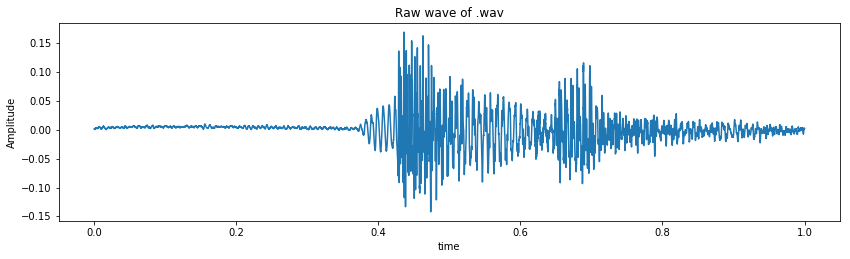

In [3]:
train_audio_path = 'G:\\Downloads\\DATABASE1\\'
samples, sample_rate = librosa.load(train_audio_path+'bagge\\madhusudhan_bagge_0.wav', sr = 16000)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + '.wav')
ax1.set_xlabel('time')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0,sample_rate/len(samples), sample_rate), samples)

In [4]:
ipd.Audio(samples, rate=sample_rate)

In [5]:
print(sample_rate)

16000


In [6]:
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples, rate=8000)

In [7]:
labels=os.listdir(train_audio_path)

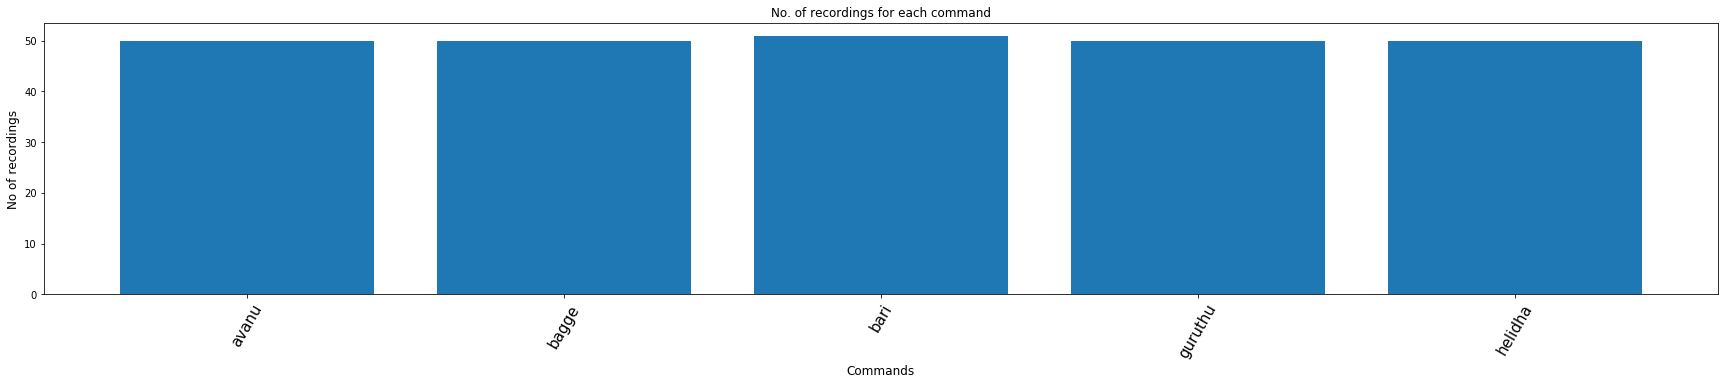

In [8]:
no_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '\\'+ label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))
    
#plot
plt.figure(figsize=(30,5))
index = np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Commands', fontsize=12)
plt.ylabel('No of recordings', fontsize=12)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('No. of recordings for each command')
plt.show()

In [9]:
labels=["avanu", "bagge", "bari", "guruthu","helidha"]

(array([  0.,   0.,   0.,   0.,   0., 251.,   0.,   0.,   0.,   0.]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5]),
 <a list of 10 Patch objects>)

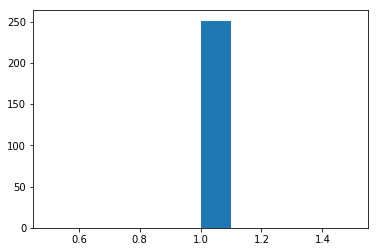

In [10]:
duration_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '\\'+ label) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + '\\' + label + '\\' + wav)
        duration_of_recordings.append(float(len(samples)/sample_rate))
    
plt.hist(np.array(duration_of_recordings))

In [13]:
train_audio_path = 'G:\\Downloads\\DATABASE1\\'

all_wave = []
all_label = []
for label in labels:
    print(label)
    waves = [f for f in os.listdir(train_audio_path + '\\'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_audio_path + '\\' + label + '\\' + wav, sr = 16000)
        samples = librosa.resample(samples, sample_rate, 8000)
        if(len(samples)== 8000) : 
            all_wave.append(samples)
            all_label.append(label)

avanu
bagge
bari
guruthu
helidha


In [14]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y=le.fit_transform(all_label)
classes= list(le.classes_)

In [15]:
from keras.utils import np_utils
y=np_utils.to_categorical(y, num_classes=len(labels))

Using TensorFlow backend.


In [16]:
all_wave = np.array(all_wave).reshape(-1,8000,1)

In [17]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(all_wave),np.array(y),stratify=y,test_size = 0.2,random_state=777,shuffle=True)

In [18]:
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
K.clear_session()

inputs = Input(shape=(8000,1))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 8000, 1)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 7988, 8)           112       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2662, 8)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2662, 8)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2652, 16)          1424      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 884, 16)           0         
_____________________________________________________

In [19]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [20]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [21]:
history=model.fit(x_tr, y_tr ,epochs=100, callbacks=[es,mc], batch_size=32, validation_data=(x_val,y_val))

Instructions for updating:
Use tf.cast instead.
Train on 200 samples, validate on 51 samples
Epoch 1/100
200/200 [==============================] - 6s 28ms/step - loss: 1.6106 - accuracy: 0.1800 - val_loss: 1.6045 - val_accuracy: 0.2745
Epoch 2/100
200/200 [==============================] - 2s 12ms/step - loss: 1.6021 - accuracy: 0.2000 - val_loss: 1.6043 - val_accuracy: 0.2157
Epoch 3/100
200/200 [==============================] - 2s 12ms/step - loss: 1.5842 - accuracy: 0.2350 - val_loss: 1.5810 - val_accuracy: 0.2549
Epoch 4/100
200/200 [==============================] - 3s 13ms/step - loss: 1.5517 - accuracy: 0.3250 - val_loss: 1.5391 - val_accuracy: 0.3529
Epoch 5/100
200/200 [==============================] - 3s 14ms/step - loss: 1.5284 - accuracy: 0.3200 - val_loss: 1.5288 - val_accuracy: 0.3922
Epoch 6/100
200/200 [==============================] - 3s 13ms/step - loss: 1.4833 - accuracy: 0.3800 - val_loss: 1.4770 - val_accuracy: 0.3529
Epoch 7/100
200/200 [======================

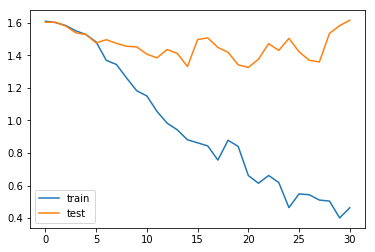

In [22]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [23]:
def predict(audio):
    prob=model.predict(audio.reshape(1,8000,1))
    index=np.argmax(prob[0])
    return classes[index]

In [49]:
import random
index=random.randint(0,len(x_val)-1)
samples=x_val[index].ravel()
print("Audio:",classes[np.argmax(y_val[index])])
ipd.Audio(samples, rate=8000)

Audio: bari


In [50]:
print("Text:",predict(samples))

Text: bari


In [42]:
model.evaluate(x_val,y_val)

51/51 [==============================] - 0s 4ms/step


[1.6166616678237915, 0.4901960790157318]